<a href="https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/master/Python_chapter_ArtificialNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習: ニューラルネットワークによる回帰



この章では、最も単純な、入力層・隠れ層・出力層からなるニューラルネットワークを使って、データから尤もらしい予測を与える関数を構築してみましょう。

対象とする(疑似)データは、多項式回帰の際に用いたデータと同じsin関数＋ノイズで生成することにします。


* すすんだ注: このノートブックでは「ニューラルネットワークをPythonで表現してみる」ことに重きをおくため、使用するデータを訓練データ,検証データ,テストデータに分けることはせず、データは全てニューラルネットワークの訓練データとして使うこととします。
授業で説明するとおり、一般に[教師あり学習]の文脈でニューラルネットワークを考える際は、本来データを上の様に複数用途に分けながら、モデル選択を行ったり、汎化性能の評価に使ったりします。

In [ ]:
import numpy as np
def create_toy_data(sample_size, std):
    np.random.seed(1234) #毎回同じデータになるように乱数の種を固定しておく 
    x = np.linspace(0, 0.5, sample_size)
    t = np.sin(2*np.pi*x) + np.random.normal(scale=std, size=x.shape)                                                                                                                 
    return x, t

xt,yt = create_toy_data(40,5.e-2) 

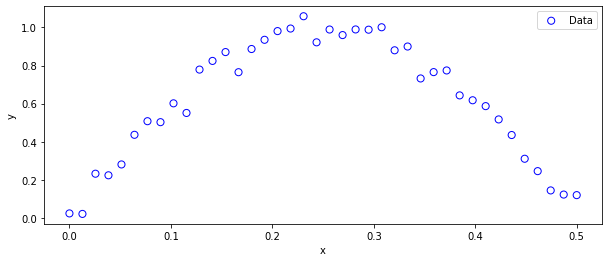

In [ ]:
###グラフにしてみる
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.scatter(xt, yt, facecolor="none", edgecolor="b", s=50, label="Data")
ax.legend()
plt.show()
plt.close()

ではいくつか必要な関数を適宜定義しながら進めていきましょう。

*注: 以下のコードは入力・出力ともに1次元かつ、決まったニューラルネットワーク構造の場合に対して書かれているため、naiveに2層以上の隠れ層を持つニューラルネットワークに拡張するのはstraightfowardではなく、また効率的ではありません。

In [ ]:
nhl = 16 ## 隠れ層のノードの数を指定 これを増やすほどニューラルネットワークの表現能力が上がる一方、データに過適合しやすくなる(例外あり)

In [ ]:
#重み行列W,V(今はベクトル)と、隠れ層でのバイアスbs,出力層でのバイアスを正規乱数で初期化
np.random.seed(1234)  #結果が実行ごとに同じになるよう乱数を固定(バグを見つけやすくする)
W = np.array([ np.random.normal() for i in range(nhl)])
V = np.array([ np.random.normal() for i in range(nhl)])
bs = np.array([np.random.normal() for i in range(nhl)])
b0 = np.random.normal()

隠れ層で作用させる活性化関数を定義しておきましょう。

In [ ]:
#シグモイド関数: 活性化関数の一つ
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

最適化したい量(データとモデルの齟齬を表す量)を目的関数(target function)やloss functionなどと呼びます。(以下でもそれに倣う)

以下では、データとANNのアウトプットの二乗誤差を目的関数として定めることにします。

In [ ]:
### データとANNの出力間の二乗誤差を計算する関数を作っておく。
def calc_tloss(x,y,tW,tV,tbs,tb0,acf):
    nhl = len(tW)
    s=0.0
    for i in range(len(x)):
        s += (np.dot(tV, acf(tW*x[i]+tbs)) + tb0 - y[i])**2
    return s

上ではcalc_tlossの引数にacfという変数を指定し、acfにsigmoidを指定しました。この様にしておくと、sigmoid関数以外の活性化関数を使う際にも、上のcalc_tloss関数が使いまわせますね。



####データの下処理

機械学習などの分析では、データの値を中心0,分散1に変換して扱うのが基本です。

このことを、データの標準化と呼びます。



In [ ]:
ymean = np.mean(yt)
ystd = np.std(yt)
ny = (np.array(yt)-ymean)/ ystd #それぞれのデータを平均をひいて標準偏差で割る

なぜ標準化が必要なのかは、今のような1次元入力データの場合よりもむしろ多変数を扱う際を考えてみるとわかります。

変数ごとに標準的なスケールが違う値を扱う場合、スケールの大きな量に学習が引っ張られる、ということが起こりえます。

たとえば目的関数を[体重と身長、それぞれについての二乗誤差の和]とする場合、  
データが50kg、ニューラルネットワークの予測が55kgで10%違っていても、二乗誤差の値は25ですが、  
身長が180cm vs 198cmと10%違っていたら、二乗誤差の値は324となります。  
したがって、目的関数は身長の予測精度により強く依存することになり、  
身長をより重視する(きちんと再現する)方向へ、ニューラルネットワークの学習が引っ張られてしまいます。

もちろん、身長をより高い精度で推測したいニューラルネットワークを構築したいなら話は別ですが、  
特定の値を特別視しない(全ての量を平等に扱う)のなら、標準化が必須です。

進んだ注)一方、最近になって、特定のアーキテクチャのネットワークを考える際に白色化が汎化性能を下げてしまう例というのも報告されています。https://arxiv.org/abs/2008.07545

In [ ]:
acf = sigmoid #sigmoid関数をacfという名前で使う

さて、初期値W,V,bs,b0と活性化関数にsigmoidを選んだニューラルネットワークとデータの値の二乗誤差は...

In [ ]:
print("初期値での二乗誤差",calc_tloss(xt,ny,W,V,bs,b0,acf))

初期値での二乗誤差 313.1095204085971


データ1個あたり、ニューラルネットワークとデータ値との間にどれくらい誤差があるかというと...

In [ ]:
print("データ1個あたりの誤差:", np.sqrt(calc_tloss(xt,ny,W,V,bs,b0,acf)/len(xt))) #データ1個あたりどれほど誤差*があるか *標準化された誤差

データ1個あたりの誤差: 2.797809502131074


ランダムに生成した重み(W,V)やバイアス項(bs,b0)では、まだニューラルネットワークは訓練がなされていないデタラメな関数なので、図にプロットしてみると...


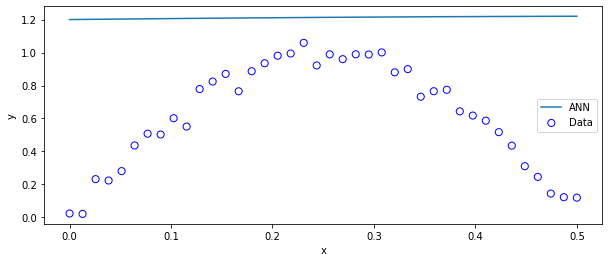

In [ ]:
xp = np.linspace(0.0,0.5,300)
yp = np.array([np.dot(V, sigmoid(W*xp[i]+bs)) for i in range(len(xp))])

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.scatter(xt, yt, facecolor="none", edgecolor="b", s=50, label="Data") 
ax.plot(xp,yp*ystd+ymean,label="ANN") #ニューラルネットワークの予測ypは、"標準化された"yの値に従って学習されているので、元のスケールに戻さないといけない。
ax.legend()
plt.show(); plt.close()

当然ですが、全然だめですね。

状況を改善するためにニューラルネットワークのパラメータを徐々に更新(学習)していきましょう。

そのためには、まず勾配を計算する関数を用意しておきます。

loss functionを$f$と書くことにすると、必要な勾配は4種類で
$\frac{\partial f}{\partial W}, \frac{\partial f}{\partial V}, \frac{\partial f}{\partial b}, \frac{\partial f}{\partial b_0}$です。  
プログラムではそれぞれ```dw,dv,dbs,db0```とでも名前をつけることにして、勾配を返り値として与える関数を定義します。

以下では、勾配降下法, Adamの2通りの最適化手法を用いてパラメータを更新することとします。

### 勾配降下法

勾配降下法とは、目的関数を微分した勾配の値のみを使ってパラメータを更新する方法です。

たとえば,重み$W$の$i$番目を更新する際には、

$W_i := W_i - \eta \frac{\partial f}{\partial W_i}$

とします。($f$は目的関数で、$\eta$は学習率(パラメータ更新のスケールを決めるパラメータ)です。)

In [ ]:
def calc_der(x,y,tW,tV,tbs,tb0,acf,acfder):
    tdw =  np.array([0.0 for i in range(len(tW))])
    tdv =  np.array([0.0 for i in range(len(tV))])
    tdbs = np.array([0.0 for i in range(len(tbs))])
    tdb0 = 0.0
    #以下の勾配の計算は、目的関数が二乗誤差かつ全データでの勾配の和を使用する場合にのみ正しい
    for i in range(len(x)):
        g = np.dot(tV, acf(tW*x[i]+tbs) ) + tb0 - y[i]
        tdb0 += 2.0 * g
        for jth in range(nhl):                    
            tdv[jth]  += 2.0 * g * acf(tW[jth]*x[i]+tbs[jth])
            tdw[jth]  += 2.0 * g * tV[jth] * acfder(tW[jth]*x[i]+tbs[jth]) *x[i]
            tdbs[jth] += 2.0 * g * tV[jth] * acfder(tW[jth]*x[i]+tbs[jth])
    return tdw, tdv, tdbs, tdb0

#シグモイド関数の微分: 勾配の計算を具体的に求めるのに使う
def sigmoid_der(z):
    return np.exp(-z)/ ((1.0+np.exp(-z))**2)

さてW,V,bs,b0の初期値での勾配の値は

In [ ]:
acf = sigmoid
acfder = sigmoid_der #sigmoid関数の微分sigmoid_derをacfderという名前で使う
calc_der(xt,ny,W,V,bs,b0,acf,acfder)

(array([  3.71768718,   3.42487069,  11.00052237, -19.86949718,
         -2.6224706 ,  -8.52137151,   1.83366782,   2.68306716,
         17.14697937,  -3.90458411,   8.31922697, -12.29443667,
         -2.17912443,   7.55129304,  -5.09567869,   4.39648691]),
 array([159.35982299, 141.67501356, 160.90790174,  94.15902163,
        101.71777326,  99.29137319, 154.96003837, 188.79870715,
        108.76124583,  52.66658505, 121.14831466,  29.22709608,
        129.31113955,  42.52714301,  93.12439202, 105.55855779]),
 array([ 15.3634969 ,  13.09474627,  48.52059886, -80.02456212,
        -10.54790346, -34.01603145,   7.73369772,  10.15640871,
         68.81205743, -18.00095629,  34.11414435, -45.52845202,
         -8.98223104,  35.20765921, -20.53605489,  17.64215683]),
 209.14938165821826)

と計算できるようになりました。

In [ ]:
def fitGD(x,y,tW,tV,tbs,tb0,acf,acfder,nepoch,eta,verbose):
    for i in range(nepoch):
        tdw,tdv,tdbs, tdb0 = calc_der(x,y,tW,tV,tbs,tb0,acf,acfder)
        tW = tW - eta * tdw
        tV = tV -eta * tdv
        tbs =  tbs -eta * tdbs
        tb0 = tb0 -eta * tdb0        
        if verbose == 1:
            print(i, "tloss =", calc_tloss(x,y,tW,tV,tbs,tb0,acf))
    return tW,tV,tbs,tb0,tdw,tdv,tdbs, tdb0

では実際に上の関数を使って、パラメータの値を更新してみましょう。(nhlの値に依りますが、ちょっぴり計算に時間がかかります)

In [ ]:
nepoch = 1000
acf = sigmoid; acfder=sigmoid_der
verbose=0
eta = 0.001 #学習率(パラメータ更新のスケールを決めるパラメータ)
W,V,bs,b0,dw,dv,dbs,db0=fitGD(xt,ny,W,V,bs,b0,acf,acfder,nepoch,eta,verbose)

更新された重み・バイアス(W,V,bs,b0)を使って、データとの二乗誤差を計算してみると...

In [ ]:
print("学習後の二乗誤差",calc_tloss(xt,ny,W,V,bs,b0,acf))

学習後の二乗誤差 39.18248205155594


すると、さっきより小さくはなっていますが、そこまで二乗誤差が減っていません。  

実際にplotしてみても

In [ ]:
xp = np.linspace(0, 0.5, 500) 
yp = 0.0*xp 
for i in range(len(yp)):
    yp[i] = np.dot(V, sigmoid(W*xp[i]+bs)) + b0 

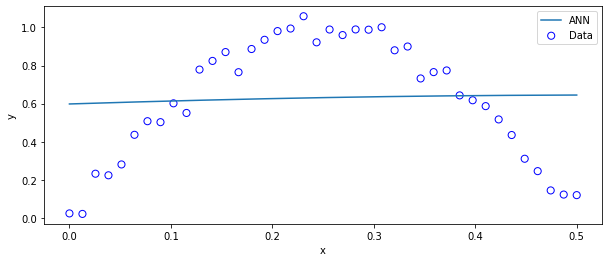

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.scatter(xt, yt, facecolor="none", edgecolor="b", s=50, label="Data")
ax.plot(xp,yp*ystd+ymean,label="ANN") ## ニューラルネットワークの出力は標準化した値に対して学習されていることに注意
ax.legend()
plt.show()
plt.close()

ほとんど学習が進んでいません...(絶望)



In [ ]:
np.random.seed(1234)
W = np.array([ np.random.normal() for i in range(nhl)])
V = np.array([ np.random.normal() for i in range(nhl)])
bs = np.array([np.random.normal() for i in range(nhl)])
b0 = np.random.normal()

学習の様子を都度printしてみる(```verbose=1```に設定する)ことにすると

In [ ]:
nepoch=20 #20回だけ学習の様子を表示
verbose=1 
print("学習前のloss", calc_tloss(xt,ny,W,V,bs,b0,acf))
#学習
W,V,bs,b0,dw,dv,dbs,db0=fitGD(xt,ny,W,V,bs,b0,acf,acfder,nepoch,eta,verbose)

学習前のloss 313.1095204085971
0 tloss = 98.10842891664797
1 tloss = 52.306327217124306
2 tloss = 42.481240439665385
3 tloss = 40.378110176044245
4 tloss = 39.9284136800197
5 tloss = 39.83184259852155
6 tloss = 39.810576416992646
7 tloss = 39.805358062718724
8 tloss = 39.803559451478186
9 tloss = 39.80249058239799
10 tloss = 39.80157854862621
11 tloss = 39.800701341234976
12 tloss = 39.799832972772975
13 tloss = 39.7989679029648
14 tloss = 39.79810494546709
15 tloss = 39.797243841016076
16 tloss = 39.796384527753446
17 tloss = 39.795526985868875
18 tloss = 39.79467120452678
19 tloss = 39.793817174827616


あるところからは、ほとんど学習が進んでいない事がわかります。

原因として考えられるのは
* loss functionをパラメータ(超)空間上にプロットした際にプラトーが存在する
* 最適化手法や学習率の設定が適切でない
* 初期値が悪い

などがあります。

勾配降下法は、最もシンプルな勾配を使った最適化手法ですが、学習の途中で勾配がほとんど0になってしまって(勾配消失ともいう)、学習が進まなくなってしまう、といったことがよく起こります。  

「勾配が小さいなら勾配にかける学習率を大きくすればええんとちゃいまんの...？」  
と思うかもしれませんが、学習率を単純に大きくしてしまうと、明後日の方向にパラメータを更新するせいで目的関数が発散してしまいます。(eta=0.1などとして試してみてください)

注) 勾配降下法を拡張した、データを部分的に使うことで学習が停滞することを防ぐ、確率的勾配降下法(Stochastic Gradient Descent; SGD)は現在もよく使われています。

以下では、Adamと呼ばれる別の最適化手法を試してみましょう。

#### Adam

Adamは、勾配降下法の様にその都度の勾配の情報だけを使うのではなく、
以前の勾配の情報も有効活用する手法です。

Adamは2014年に提唱された比較的新しい手法で、以降の機械学習の論文では、Adamが最もよく使われています。(*最も"良い"という意味では必ずしもありません)

In [ ]:
def updateAdam(A,mt,vt,i,beta1,beta2,eps):
    mhat = mt / (1.0-beta1**(i+1))
    vhat = vt / (1.0-beta2**(i+1))
    return mhat / (np.sqrt( vhat )+eps)

def fitAdam(x,y,tW,tV,tbs,tb0,acf,acfder,nepoch,eta,verbose):
    #新たに必要なものを定義しておく。
    mt_w = np.array([0.0 for i in range(len(tW))])
    mt_v = np.array([0.0 for i in range(len(tV))])
    mt_bs = np.array([0.0 for i in range(len(tbs))])
    mt_b0 = 0.0
    vt_w = np.array([0.0 for i in range(len(tW))])
    vt_v = np.array([0.0 for i in range(len(tV))])
    vt_bs = np.array([0.0 for i in range(len(tbs))])
    vt_b0 = 0.0
    #########
    beta1 = 0.9
    beta2 = 0.999
    eps = 1.e-8
    #########
    for i in range(nepoch):
        tdw,tdv,tdbs, tdb0 = calc_der(x,y,tW,tV,tbs,tb0,acf,acfder)   ### 勾配を計算するところまでは同じ。
        # mt と vtたちの更新 ベクトルをブロードキャストで更新していることに注意
        mt_w = beta1 * mt_w + (1.0-beta1)*tdw
        vt_w = beta2 * vt_w + (1.0-beta2)*(tdw**2)
        mt_v = beta1 * mt_v + (1.0-beta1)*tdv
        vt_v = beta2 * vt_v + (1.0-beta2)*(tdv**2)
        mt_bs = beta1 * mt_bs + (1.0-beta1)*tdbs
        vt_bs = beta2 * vt_bs + (1.0-beta2)*(tdbs**2)
        mt_b0 = beta1*mt_b0 + (1.0-beta1)*tdb0
        vt_b0 = beta2*vt_b0 + (1.0-beta2)*(tdb0**2)
        ### 重み・バイアスの更新
        tW += -eta * updateAdam(tW, mt_w,vt_w,i,beta1,beta2,eps)
        tV += -eta * updateAdam(tV, mt_v,vt_v,i,beta1,beta2,eps)
        tbs += -eta * updateAdam(tbs,mt_bs,vt_bs,i,beta1,beta2,eps)
        tb0 += -eta *  (mt_b0/(1.0-beta1**(i+1))) / ( np.sqrt( vt_b0/ (1.0-beta2**(i+1))) + eps)
        if verbose == 1 and i % 500 == 0:
            print(i, "tloss =", calc_tloss(x,y,tW,tV,tbs,tb0,acf))
    return tW,tV,tbs,tb0,tdw,tdv,tdbs, tdb0

それでは重みを初期化して、再び学習をしてみましょう

In [ ]:
np.random.seed(1234) ## Gradient descentと同条件でスタートするため
W = np.array([ np.random.normal() for i in range(nhl)])
V = np.array([ np.random.normal() for i in range(nhl)])
bs = np.array([np.random.normal() for i in range(nhl)])
b0 = np.random.normal()
nepoch=2000
verbose=0
eta = 0.01
acf = sigmoid ; acfder =sigmoid_der
print("学習前のloss", calc_tloss(xt,ny,W,V,bs,b0,acf))
W,V,bs,b0,dw,dv,dbs,db0=fitAdam(xt,ny,W,V,bs,b0,acf,acfder,nepoch,eta,verbose)
print("学習後のloss", calc_tloss(xt,ny,W,V,bs,b0,acf))

学習前のloss 313.1095204085971
学習後のloss 1.0073769153776333


さっきより2桁近くlossの値が小さくなっています。学習がうまく行ってそうですね。

グラフにしてみると...

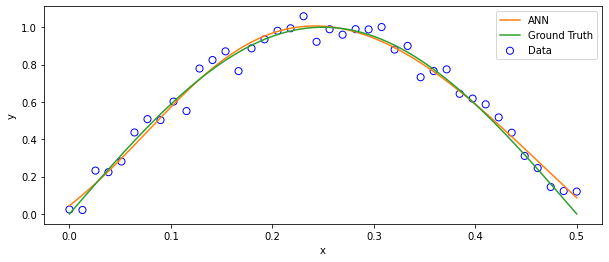

In [ ]:
xp = np.linspace(0, 0.5, 500) 
yp = 0.0*xp 
for i in range(len(yp)):
    yp[i] = np.dot(V, sigmoid(W*xp[i]+bs)) + b0 
ytruth = np.sin(2*np.pi*xp)
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.scatter(xt, yt, facecolor="none", edgecolor="b", s=50, label="Data")
ax.plot(xp,yp*ystd+ymean,color="C01",label="ANN")
ax.plot(xp,ytruth,color="C02",label="Ground Truth")
ax.legend()
plt.show()
plt.close()

のように、データの特徴をそこそこうまく捉えたニューラルネットワークへと学習が進みました。

実際には、ニューラルネットワークの精度(良さ)は、前述のような検証データに対する汎化性能で評価します。  

上で示した例では、3層のニューラルネットワークにデータからそれらしい関数を学習させてみました。

ニューラルネットワークの構造をより複雑化したりしながら、より複雑で高次元な回帰問題に応用したり、回帰問題だけではなく分類問題・画像生成・物体検知などなど、各種の楽しい実社会の問題に応用していきます。 (例: 第2回で説明した敵対的生成ネットワーク)


### 最適化手法に関するまとめ

ニューラルネットワークの学習がうまく進むかどうかは一般に
1. ネットワークの構造(アーキテクチャとも言ったりします)や活性化関数(とその微分)の持つ性質
2. 最適化手法や手法内のパラメータ
3. 重みやバイアスの初期値

などに強く依存します。

1.に関して   
回帰問題における代表的な活性化関数としては
最近の傾向として、sigmoidよりも以下のReLU関数が使われることが多いです。  






In [ ]:
def relu(z):
    return (z > 0)* z   

def relu_der(z):
     return (z > 0)*1.0 
     
#いずれも、zが実数値でもnp.array型のベクトルでも対応可能な表式

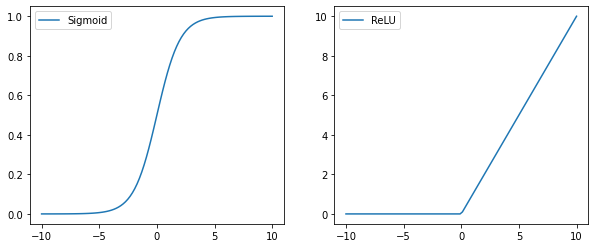

In [ ]:
##適当な区間のxの値を用意する
xp = np.linspace(-10.0,10.0,100)
yp_sigmoid = sigmoid(xp)
yp_relu = relu(xp)

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.plot(xp,yp_sigmoid,label="Sigmoid")
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(xp,yp_relu,label="ReLU")
ax2.legend()
plt.show()
plt.close()

sigmoid関数はx->+∞で1.0, x=-∞で-1.0に漸近します。

一方でReLU関数はx=0までは0.0で、x>0.0で、xとなるような関数です。


なぜReLUがよく使われる様になったかと言うと、  
(特に隠れ層の数が多い深層学習において)学習するにつれて勾配の値が小さくなって学習が進まない、
という問題を解決するためです。

それぞれの関数の微分を表示してみると

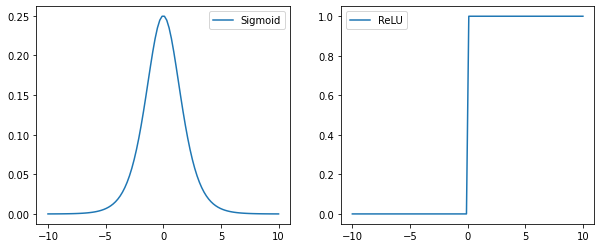

In [ ]:
xp = np.linspace(-10.0,10.0,100)
yp_sigmoid = sigmoid_der(xp)
yp_relu = relu_der(xp)

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.plot(xp,yp_sigmoid,label="Sigmoid")
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(xp,yp_relu,label="ReLU")
ax2.legend()
plt.show()
plt.close()

sigmoid関数は微分の値が最大で0.25なのに対して、ReLU関数では最大1.0となるため勾配の消失が起こりにくいのです。

問題ごとに何が最適なネットワーク構造だったり活性化関数なのかは、  
予め分かることはなく、試行錯誤が必要です。  
ここまでこの授業で勉強してきた皆さんは既に、  
「この試行錯誤自体を人力ではなくコンピュータにやらせる方法はないか」という点に思い至るのではないでしょうか?

これに関連したお話は後の回で説明したいと思います。

3.に関して

また、ネットワークの重みやバイアスをどのような値から始めるかに学習が依存する場合もあります。

というのも、今考えた３層のニューラルネットワークでは、  
重み$W$の学習に使う勾配の表式は、$V$に比例しています。

したがって単純に勾配の情報のみを使う最適化手法では、  
$V$の初期値を0に取ったり、学習の過程で偶然$V$の値が0に近くなってしまうと、  
$V$が更新されノンゼロの値を持つまで$W$の学習は始まりません。

どのような初期値を採用するべきかに関しても、予め知ることは一般にはできませんが、  
いくつかの特定の場合に関して、推奨される方法というのは存在しています。

例: ReLU関数を活性化関数に使うときはHeの初期値というものが推奨されている